In [1]:
import os
import logging
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kaggle.api.kaggle_api_extended import KaggleApi
from pathlib import Path

from utils import DepressionDataProcessor

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, f1_score, recall_score, 
    roc_curve, auc, ConfusionMatrixDisplay
)

import shap
from catboost import CatBoostClassifier

plt.style.use('ggplot')
%matplotlib inline

ISKAGGLE = os.environ.get("KAGGLE_KERNEL_RUN_TYPE", "") != ""

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


In [2]:
class TelcoDataProcessor:
    def __init__(self, path="customer-churn-prediction-2020"):
        self.path = path
        self.column_transformer = None
        self.is_kaggle = ISKAGGLE

    def download_and_extract(self):
        if not self.is_kaggle and not Path(self.path).exists():
            zip_path = Path(f"{self.path}.zip")
            if not zip_path.exists():
                import kaggle
                kaggle.api.competition_download_cli('customer-churn-prediction-2020')
            with zipfile.ZipFile(zip_path, 'r') as zf:
                zf.extractall(self.path)
            print("Dataset extracted successfully.")
        
        if self.is_kaggle:
            self.path = '/kaggle/input/customer-churn-prediction-2020'  # Set Kaggle path explicitly

    def load_data(self, filename):
        try:
            return pd.read_csv(f"{self.path}/{filename}")
        except FileNotFoundError:
            print(f"File {filename} not found in path {self.path}.")
            return None

    def preprocess(self, df):
        df = df.copy()  # Make a copy at the start

        # Feature Engineering
        df['total_charge_per_minute'] = df['total_day_charge'] / df['total_day_minutes']
        df['international_charge_per_minute'] = df['total_intl_charge'] / df['total_intl_minutes']
        df['night_charge_per_minute'] = df['total_night_charge'] / df['total_night_minutes']
        df['eve_charge_per_minute'] = df['total_eve_charge'] / df['total_eve_minutes']
        df['day_charge_per_minute'] = df['total_day_charge'] / df['total_day_minutes']

        # Calculate averages
        avg_total_charge_per_minute = df['total_charge_per_minute'].mean()
        avg_intl_charge_per_minute = df['international_charge_per_minute'].mean()
        avg_night_charge_per_minute = df['night_charge_per_minute'].mean()
        avg_eve_charge_per_minute = df['eve_charge_per_minute'].mean()
        avg_day_charge_per_minute = df['day_charge_per_minute'].mean()

        # Calculate over average features
        df['total_charge_per_minute_over_average'] = df['total_charge_per_minute'] / avg_total_charge_per_minute
        df['international_charge_per_minute_over_average'] = df['international_charge_per_minute'] / avg_intl_charge_per_minute
        df['night_charge_per_minute_over_average'] = df['night_charge_per_minute'] / avg_night_charge_per_minute
        df['eve_charge_per_minute_over_average'] = df['eve_charge_per_minute'] / avg_eve_charge_per_minute
        df['day_charge_per_minute_over_average'] = df['day_charge_per_minute'] / avg_day_charge_per_minute

        # Calculate over average by area code
        df['total_charge_per_minute_over_average_by_area_code'] = df.groupby('area_code')['total_charge_per_minute'].transform(lambda x: x / x.mean())
        df['international_charge_per_minute_over_average_by_area_code'] = df.groupby('area_code')['international_charge_per_minute'].transform(lambda x: x / x.mean())
        df['night_charge_per_minute_over_average_by_area_code'] = df.groupby('area_code')['night_charge_per_minute'].transform(lambda x: x / x.mean())
        df['eve_charge_per_minute_over_average_by_area_code'] = df.groupby('area_code')['eve_charge_per_minute'].transform(lambda x: x / x.mean())
        df['day_charge_per_minute_over_average_by_area_code'] = df.groupby('area_code')['day_charge_per_minute'].transform(lambda x: x / x.mean())

        # Calculate over average by state
        df['total_charge_per_minute_over_average_by_state'] = df.groupby('state')['total_charge_per_minute'].transform(lambda x: x / x.mean())
        df['international_charge_per_minute_over_average_by_state'] = df.groupby('state')['international_charge_per_minute'].transform(lambda x: x / x.mean())
        df['night_charge_per_minute_over_average_by_state'] = df.groupby('state')['night_charge_per_minute'].transform(lambda x: x / x.mean())
        df['eve_charge_per_minute_over_average_by_state'] = df.groupby('state')['eve_charge_per_minute'].transform(lambda x: x / x.mean())
        df['day_charge_per_minute_over_average_by_state'] = df.groupby('state')['day_charge_per_minute'].transform(lambda x: x / x.mean())

        # Convert object columns to category
        for col in df.select_dtypes(include='object').columns:
            df[col] = df[col].astype('category')

        return df  # No need for an extra processed_df variable


# Data Loading

In [3]:
processor = TelcoDataProcessor()
processor.download_and_extract()

In [4]:
train_raw_df = processor.load_data("train.csv")
test_raw_df = processor.load_data("test.csv")
submission_raw_df = processor.load_data("sampleSubmission.csv")

## Data Descriptions

- **state**: string. 2-letter code of the US state of customer residence
- **account_length**: numerical. Number of months the customer has been with the current telco provider
- **area_code**: string="area_code_AAA" where AAA = 3 digit area code.
- **international_plan**: (yes/no). The customer has international plan.
- **voice_mail_plan**: (yes/no). The customer has voice mail plan.

- **number_vmail_messages**: numerical. Number of voice-mail messages.
- **total_day_minutes**: numerical. Total minutes of day calls.
- **total_day_calls**: numerical. Total number of day calls.
- **total_day_charge**: numerical. Total charge of day calls.
- **total_eve_minutes**: numerical. Total minutes of evening calls.
- **total_eve_calls**: numerical. Total number of evening calls.

- **total_eve_charge**: numerical. Total charge of evening calls.

- **total_night_minutes**: numerical. Total minutes of night calls.
- **total_night_calls**: numerical. Total number of night calls.

- **total_night_charge**: numerical. Total charge of night calls.

- **total_intl_minutes**: numerical. Total minutes of international calls.
- **total_intl_calls**: numerical. Total number of international calls.

- **total_intl_charge**: numerical. Total charge of international calls.

- **number_customer_service_calls**: numerical. Number of calls to customer service.

**TARGET**
- **churn**: (yes/no). Customer churn - target variable.


**Hypotheses**
- I imagine customer service calls are a key indicator
- I also think the cost per call type will be a big factor and more so depending on the calls they make, maybe need to aggregate into something like a total charge per minute for calls?
- Maybe a feature of charge per minute vs average for a customer, ratio, this could also be based on the average over the state also could be done against area code

### Feature Columns to Create


- **Total Charge per Minute**
    - `total charge per minute`
    - `total charge per minute over average`
    - `total charge per minute over average by area code`
    - `total charge per minute over average by state`

- **International Charge per Minute**
    - `international charge per minute`
    - `international charge per minute over average`
    - `international charge per minute over average by area code`
    - `international charge per minute over average by state`

- **Night Charge per Minute**
    - `night charge per minute`
    - `night charge per minute over average`
    - `night charge per minute over average by area code`
    - `night charge per minute over average by state`

- **Evening Charge per Minute**
    - `eve charge per minute`
    - `eve charge per minute over average`
    - `eve charge per minute over average by area code`
    - `eve charge per minute over average by state`

- **Day Charge per Minute**
    - `day charge per minute`
    - `day charge per minute over average`
    - `day charge per minute over average by area code`
    - `day charge per minute over average by state`

In [5]:
train_raw_df.select_dtypes(include='integer')

,account_length,number_vmail_messages,total_day_calls,total_eve_calls,total_night_calls,total_intl_calls,number_customer_service_calls
0,107,26,123,103,103,3,1
1,137,0,114,110,104,5,0
2,84,0,71,88,89,7,2
3,75,0,113,122,121,3,3
4,121,24,88,108,118,7,3
...,...,...,...,...,...,...,...
4245,83,0,70,88,79,6,0
4246,73,0,89,82,89,6,3
4247,75,0,101,126,104,7,1
4248,50,40,127,126,116,5,2


In [6]:
train_raw_df.select_dtypes(include='float')

,total_day_minutes,total_day_charge,total_eve_minutes,total_eve_charge,total_night_minutes,total_night_charge,total_intl_minutes,total_intl_charge
0,161.6,27.47,195.5,16.62,254.4,11.45,13.7,3.70
1,243.4,41.38,121.2,10.30,162.6,7.32,12.2,3.29
2,299.4,50.90,61.9,5.26,196.9,8.86,6.6,1.78
3,166.7,28.34,148.3,12.61,186.9,8.41,10.1,2.73
4,218.2,37.09,348.5,29.62,212.6,9.57,7.5,2.03
...,...,...,...,...,...,...,...,...
4245,188.3,32.01,243.8,20.72,213.7,9.62,10.3,2.78
4246,177.9,30.24,131.2,11.15,186.2,8.38,11.5,3.11
4247,170.7,29.02,193.1,16.41,129.1,5.81,6.9,1.86
4248,235.7,40.07,223.0,18.96,297.5,13.39,9.9,2.67


In [7]:
sorted_columns = train_raw_df.columns.to_series().groupby(train_raw_df.dtypes).groups
sorted_columns = [col for dtype in sorted_columns.keys() for col in sorted_columns[dtype]]
train_raw_df = train_raw_df[sorted_columns]
train_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_length                 4250 non-null   int64  
 1   number_vmail_messages          4250 non-null   int64  
 2   total_day_calls                4250 non-null   int64  
 3   total_eve_calls                4250 non-null   int64  
 4   total_night_calls              4250 non-null   int64  
 5   total_intl_calls               4250 non-null   int64  
 6   number_customer_service_calls  4250 non-null   int64  
 7   total_day_minutes              4250 non-null   float64
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_charge               4250 non-null   float64
 11  total_night_minutes            4250 non-null   float64
 12  total_night_charge             4250 non-null   f

In [8]:
train_raw_df.describe()

,account_length,number_vmail_messages,total_day_calls,total_eve_calls,total_night_calls,total_intl_calls,number_customer_service_calls,total_day_minutes,total_day_charge,total_eve_minutes,total_eve_charge,total_night_minutes,total_night_charge,total_intl_minutes,total_intl_charge
count,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,100.236235,7.631765,99.907294,100.176471,99.839529,4.426353,1.559059,180.259600,30.644682,200.173906,17.015012,200.527882,9.023892,10.256071,2.769654
std,39.698401,13.439882,19.850817,19.908591,20.093220,2.463069,1.311434,54.012373,9.182096,50.249518,4.271212,50.353548,2.265922,2.760102,0.745204
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,87.000000,87.000000,86.000000,3.000000,1.000000,143.325000,24.365000,165.925000,14.102500,167.225000,7.522500,8.500000,2.300000
50%,100.000000,0.000000,100.000000,100.000000,100.000000,4.000000,1.000000,180.450000,30.680000,200.700000,17.060000,200.450000,9.020000,10.300000,2.780000
75%,127.000000,16.000000,113.000000,114.000000,113.000000,6.000000,2.000000,216.200000,36.750000,233.775000,19.867500,234.700000,10.560000,12.000000,3.240000
max,243.000000,52.000000,165.000000,170.000000,175.000000,20.000000,9.000000,351.500000,59.760000,359.300000,30.540000,395.000000,17.770000,20.000000,5.400000


In [9]:
train_raw_df.describe(include='object')

,state,area_code,international_plan,voice_mail_plan,churn
count,4250,4250,4250,4250,4250
unique,51,3,2,2,2
top,WV,area_code_415,no,no,no
freq,139,2108,3854,3138,3652


In [10]:
shared_features = np.intersect1d(train_raw_df.columns, test_raw_df.columns)

In [11]:
for feature in train_raw_df.select_dtypes(include='object').columns:
        print(f'{feature}: {train_raw_df[feature].unique()}')

state: ['OH' 'NJ' 'OK' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY' 'ID' 'VA'
 'TX' 'FL' 'CO' 'AZ' 'SC' 'WY' 'HI' 'NH' 'AK' 'GA' 'MD' 'AR' 'WI' 'OR'
 'MI' 'DE' 'UT' 'CA' 'SD' 'NC' 'WA' 'MN' 'NM' 'NV' 'DC' 'VT' 'KY' 'ME'
 'MS' 'AL' 'NE' 'KS' 'TN' 'IL' 'PA' 'CT' 'ND']
area_code: ['area_code_415' 'area_code_408' 'area_code_510']
international_plan: ['no' 'yes']
voice_mail_plan: ['yes' 'no']
churn: ['no' 'yes']


### Looking at the imbalance of the target
- we need to use stratify target in train test split to maintain balance
- we need to use the ratio in scale_pos_weight in the model
- we probably want to target recall score

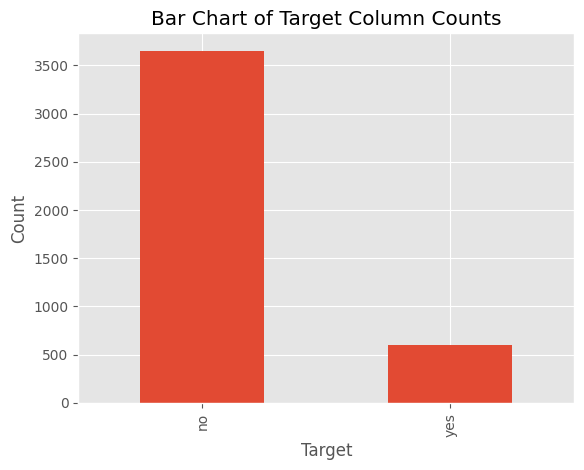

In [14]:
train_raw_df['churn'].value_counts().plot(kind='bar')
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Bar Chart of Target Column Counts')
plt.show()

## Modeling

In [15]:
target = 'churn'

features = [
    'state',
    'account_length',
    'area_code',
    'international_plan',
    'voice_mail_plan',
    'number_vmail_messages',
    'total_day_minutes',
    'total_day_calls',
    'total_day_charge',
    'total_eve_minutes',
    'total_eve_calls',
    'total_eve_charge',
    'total_night_minutes',
    'total_night_calls',
    'total_night_charge',
    'total_intl_minutes',
    'total_intl_calls',
    'total_intl_charge',
    'number_customer_service_calls',
    'total_charge_per_minute',
    'total_charge_per_minute_over_average',
    'total_charge_per_minute_over_average_by_area_code',
    'total_charge_per_minute_over_average_by_state',
    'international_charge_per_minute',
    'international_charge_per_minute_over_average',
    'international_charge_per_minute_over_average_by_area_code',
    'international_charge_per_minute_over_average_by_state',
    'night_charge_per_minute',
    'night_charge_per_minute_over_average',
    'night_charge_per_minute_over_average_by_area_code',
    'night_charge_per_minute_over_average_by_state',
    'eve_charge_per_minute',
    'eve_charge_per_minute_over_average',
    'eve_charge_per_minute_over_average_by_area_code',
    'eve_charge_per_minute_over_average_by_state',
    'day_charge_per_minute',
    'day_charge_per_minute_over_average',
    'day_charge_per_minute_over_average_by_area_code',
    'day_charge_per_minute_over_average_by_state'
]

# Prepare the data
X = train_raw_df.drop(columns=[target])
y = train_raw_df[target]

# Convert target variable to category
y = y.astype('category').cat.codes

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

X_train_processed = processor.preprocess(X_train)
X_test_processed = processor.preprocess(X_test)

# Model Fitting

- I use stratify to ensure test and train have the same imbalance of classes
- I use sample_pos_weight to deal with the imbalanced target and help with the F1 score
---

- We can increase the sample weights to push the model toward more false positives so that we dont miss churners

In [16]:
accuracy = []
recall = []
roc_auc = []
precision = []
f1_scores = []
model_names = []

categorical_features_indices = np.where(X_train_processed.dtypes == 'category')[0]

class_weights = y_train.value_counts()[0] / y_train.value_counts()[1]

tuned_params = {
    "iterations": 501,
    "depth": 5,
    "learning_rate": 0.05738634862977308,
    "scale_pos_weight": class_weights,
    "bagging_temperature": 0.38138547122967104,
    "l2_leaf_reg": 1.11829190438502,
    "border_count": 76,
    "task_type": "GPU" if os.environ.get("CUDA_VISIBLE_DEVICES") else "CPU",
    "devices": "",
    "eval_metric": "F1",
    "verbose": False
}

catboost_base = CatBoostClassifier(**tuned_params)
catboost_base.fit(X_train_processed, y_train, cat_features=categorical_features_indices)

# Model Evaluation

In [17]:
y_pred = catboost_base.predict(X_test_processed)

accuracy.append(round(accuracy_score(y_test, y_pred), 4))
recall.append(round(recall_score(y_test, y_pred), 4))
roc_auc.append(round(roc_auc_score(y_test, y_pred), 4))
precision.append(round(precision_score(y_test, y_pred, zero_division=0), 4))
f1_scores.append(round(f1_score(y_test, y_pred), 4))

model_names.append('Catboost_normal_weight')

result_df1 = pd.DataFrame({'Accuracy': accuracy, 'Recall': recall, 'Roc_Auc': roc_auc, 'Precision': precision, 'F1 Score': f1_scores}, index=model_names)
result_df1

,Accuracy,Recall,Roc_Auc,Precision,F1 Score
Catboost_normal_weight,0.9541,0.7583,0.8723,0.901,0.8235


                        Accuracy  Recall  Roc_Auc  Precision  F1 Score
Catboost_normal_weight    0.9541  0.7583   0.8723      0.901    0.8235


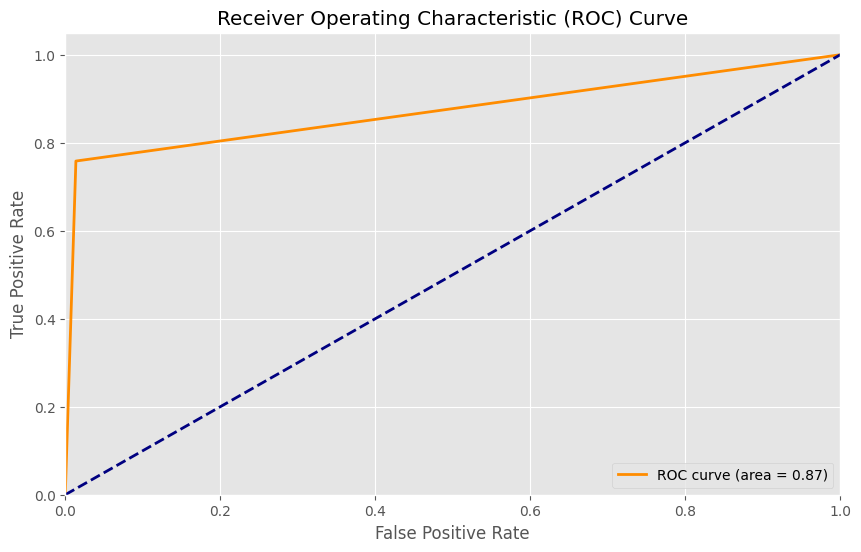

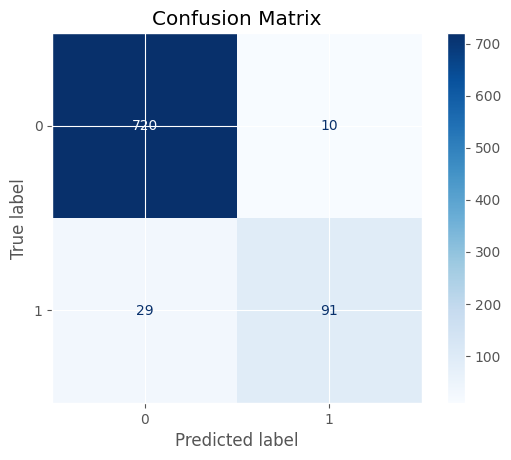

In [ ]:
print(result_df1)

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

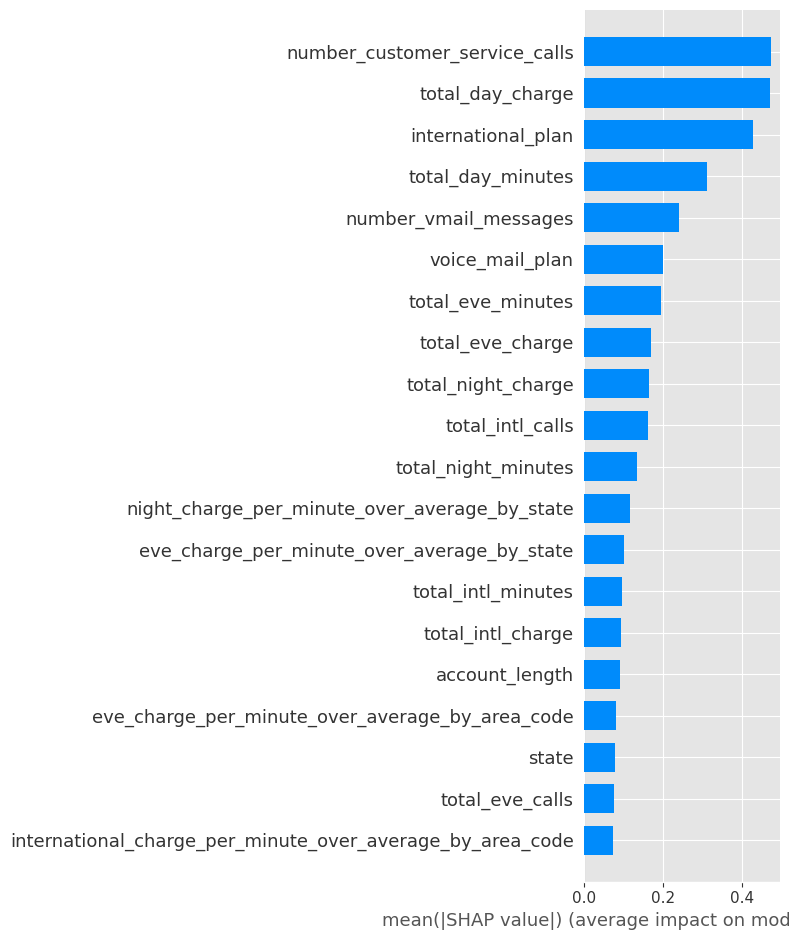

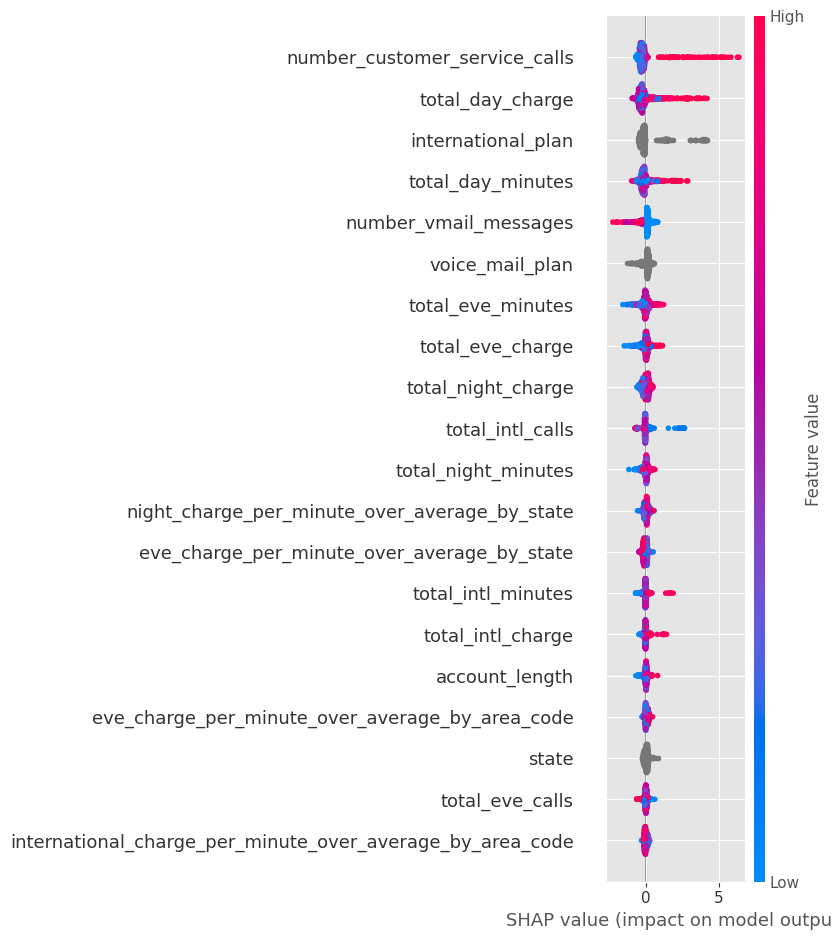

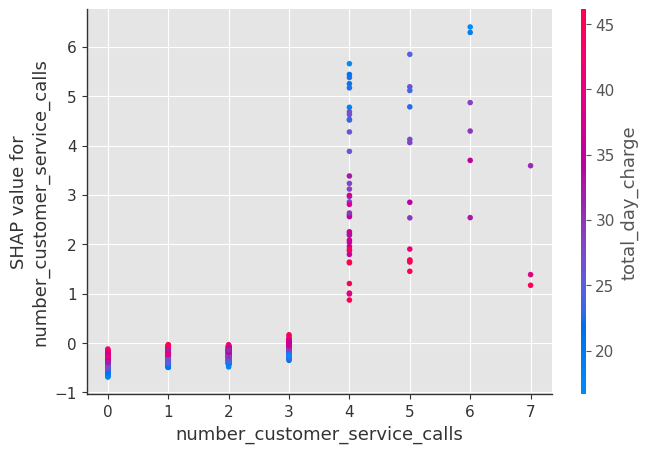

In [ ]:
explainer = shap.TreeExplainer(catboost_base)

shap_values = explainer.shap_values(X_test_processed)

shap.summary_plot(shap_values, X_test_processed, plot_type="bar")

shap.summary_plot(shap_values, X_test_processed)

shap.dependence_plot("number_customer_service_calls", shap_values, X_test_processed)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_processed.iloc[0,:])

## Submission

In [20]:
class_weights = y_train.value_counts()[0] / y_train.value_counts()[1]

tuned_params = {
    "iterations": 501,
    "depth": 5,
    "learning_rate": 0.05738634862977308,
    "scale_pos_weight": class_weights,
    "bagging_temperature": 0.38138547122967104,
    "l2_leaf_reg": 1.11829190438502,
    "border_count": 76,
    "task_type": "GPU" if os.environ.get("CUDA_VISIBLE_DEVICES") else "CPU",
    "devices": "",
    "eval_metric": "F1",
    "verbose": False
}

X_processed = processor.preprocess(X)

categorical_features_indices = np.where(X_processed.dtypes == 'category')[0]

catboost_submission = CatBoostClassifier(**tuned_params)
catboost_submission.fit(X_processed, y, cat_features=categorical_features_indices)

In [23]:
X_submission = test_raw_df[X.columns]
X_submission_processed = processor.preprocess(X_submission)
y_submission = catboost_submission.predict(X_submission_processed)
submission_df = pd.DataFrame({'id': test_raw_df['id'], 'churn': y_submission})

In [24]:
submission_df['churn'] = submission_df['churn'].map({1: 'yes', 0: 'no'})
submission_raw_df.drop('churn', axis = 1).merge(submission_df, on='id').to_csv('submission.csv', index=False)